In [3]:
import matplotlib.pyplot as plt # to make plots
import numpy as np # for array manipulation and math functions
import scipy.signal as scs # for signal analysis
import glob # for finding files
import os as os
import warnings
import array as arr
import uncertainties
from scipy import optimize
from scipy.optimize import curve_fit
from uncertainties import ufloat as uf
from uncertainties.umath import *
from uncertainties import unumpy as un
# import fit models from the lmfit package
from lmfit.models import ExponentialModel, GaussianModel, PolynomialModel

path2='../Versuch 526/Rohdaten/Tag 2/'
path1='../Versuch 526/Rohdaten/'
path_gaus='./gaus/'
path_raw='./raw/'
winkel=[]
winkeler=[]
for h in range(0,18):
    winkel.append(h*5+35)
    winkeler.append(1)
def E_kal(kanal,m,b):
    return m*kanal+b

def Effizienz(E,A,B,C,D):
    # return (P1+P2*np.log(E)+P4*np.log(E)**3+P5*np.log(E)**4    +P3*np.log(E)**2)/E
    return A-B*np.exp(C*(E+D))
def uEffizienz(E,A,B,C,D):
    # return (P1+P2*np.log(E)+P4*np.log(E)**3+P5*np.log(E)**4    +P3*np.log(E)**2)/E
    return A-B*exp(C*(E+D))
def Gausfit_1(winkel,x,y,namena,amplitude,center,sigma,dont_show):
    x1 = x
    y1 = y
    model = (GaussianModel(prefix='g1_'))
    params = model.make_params(g1_amplitude=amplitude,
                            g1_center=center,
                            g1_sigma=sigma)
    result = model.fit(y1, params, x=x1)
    # print(result.fit_report(min_correl=0.5))
    lolo1=[]
    lala1=[]
    for name,param in result.params.items():
        if result.errorbars==True:
            lala1.append(param.stderr)
        else:
            lala1.append(0)
        lolo1.append(param.value)
    comps = result.eval_components(x=x1)
    dely = result.eval_uncertainty(sigma=3)
    ergebnis = model.eval(params,x=x1)
    figure=plt.figure(figsize=(10,6))
    plt.title('Gaußkurvenfit an das korrigierte Cs-Streuspektrum bei '+str(winkel)+'$^{\circ}$',fontsize=15)
    plt.plot(x1,y1,"b-",linewidth=.2,label="Messwerte",)
    plt.plot(x1,result.best_fit,"r-",label="Gaußkurve",)
    plt.xlabel('Energie [keV]',fontsize=12)
    plt.ylabel('Zählrate',fontsize=12)
    plt.grid()
    plt.legend(fontsize=12)
    plt.savefig(namena+'.png')
    if (dont_show==1):
        plt.close(figure)
    #plt.show
    return lolo1,lala1

def klein_nishina(E,theta):
    t=theta*np.pi/180
    alpha=1/137
    m=511
    E_bar=E/(1+E/m*(1-np.cos(t)))
    return 0.5*(alpha*E_bar/(m*E))**2*(E_bar/E+E/E_bar-np.sin(t)**2)

def klein_nishina_ebar(E,theta,E_bar):
    t=theta*np.pi/180
    alpha=1/137
    m=511
    return 0.5*(alpha*E_bar/(m*E))**2*(E_bar/E+E/E_bar-np.sin(t)**2)

def klein_nishina_for_fit(theta,E_bar_off,theta_off,E_off):
    t=theta*np.pi/180
    alpha=1/137
    # E_bar_off=0
    # theta_off=0
    b=0
    E=647.12702085
    m=511
    E_bar=(E+E_off)/(1+(E+E_off)/m*(1-np.cos(t+theta_off*np.pi/180)))
    return 0.5*(alpha*(E_bar+E_bar_off)/(m*E))**2*((E_bar+E_bar_off)/E+E/(E_bar+E_bar_off)-np.sin(t+theta_off*np.pi/180)**2)+b

def klein_nishina_for_fit_no_E_off(theta,E_bar_off,theta_off):
    t=theta*np.pi/180
    alpha=1/137
    # E_bar_off=0
    E_off=0
    # theta_off=0
    b=0
    E=647.12702085
    m=511
    E_bar=(E+E_off)/(1+(E+E_off)/m*(1-np.cos(t+theta_off*np.pi/180)))
    return 0.5*(alpha*(E_bar+E_bar_off)/(m*E))**2*((E_bar+E_bar_off)/E+E/(E_bar+E_bar_off)-np.sin(t+theta_off*np.pi/180)**2)+b

def klein_nishina_for_fit_no_E_off_and_theta_off(theta,E_bar_off):
    t=theta*np.pi/180
    alpha=1/137
    # E_bar_off=0
    E_off=0
    theta_off=0
    b=0
    E=647.12702085
    m=511
    E_bar=(E+E_off)/(1+(E+E_off)/m*(1-np.cos(t+theta_off*np.pi/180)))
    return 0.5*(alpha*(E_bar+E_bar_off)/(m*E))**2*((E_bar+E_bar_off)/E+E/(E_bar+E_bar_off)-np.sin(t+theta_off*np.pi/180)**2)+b

def klein_nishina_for_fit_no_E_off_and_E_bar_off(theta,theta_off):
    t=theta*np.pi/180
    alpha=1/137
    E_bar_off=0
    E_off=0
    # theta_off=0
    b=0
    E=647.12702085
    m=511
    E_bar=(E+E_off)/(1+(E+E_off)/m*(1-np.cos(t+theta_off*np.pi/180)))
    return 0.5*(alpha*(E_bar+E_bar_off)/(m*E))**2*((E_bar+E_bar_off)/E+E/(E_bar+E_bar_off)-np.sin(t+theta_off*np.pi/180)**2)+b

def knff(var,b):
    alpha=((1/137)/511)**2
    return (alpha)*(var+b)

def kn_var(theta,E_bar):
    t=theta*np.pi/180
    E=647.12702085
    return 0.5*(E_bar/E)**2*(E_bar/E+E/E_bar-np.sin(t)**2)

def E(theta, E):
    t=theta*np.pi/180
    theta_off=0
    E_off=0
    m=511
    return (E-E_off)/(1+(E-E_off)/m*(1-np.cos(t-theta_off*np.pi/180)))

def E2(E_bar, E):
    # t=theta*np.pi/180
    theta_off=0
    E_off=0
    m=511
    return 1-m*(1/E_bar-1/E)

def Gausfit_11(x,y,amplitude,center,sigma):
    x1 = x
    y1 = y
    model = (GaussianModel(prefix='g1_'))
    params = model.make_params(g1_amplitude=amplitude,
                            g1_center=center,
                            g1_sigma=sigma)
    result = model.fit(y1, params, x=x1)
    #print(result.fit_report(min_correl=0.5))
    lolo1=[]
    lala1=[]
    for name,param in result.params.items():
        if result.errorbars==True:
            lala1.append(param.stderr)
        else:
            lala1.append(0)
        lolo1.append(param.value)
    comps = result.eval_components(x=x1)
    dely = result.eval_uncertainty(sigma=3)
    ergebnis = model.eval(params,x=x1)
    return lolo1,lala1,result.best_fit

def Gausfit_2(x,y,amplitude,center,sigma):
    x1 = x
    y1 = y
    model = (GaussianModel(prefix='g1_') +
             GaussianModel(prefix='g2_'))
    params = model.make_params(g1_amplitude=amplitude,
                            g1_center=center,
                            g1_sigma=sigma,
                            g2_amplitude=amplitude,
                            g2_center=center,
                            g2_sigma=sigma)
    result = model.fit(y1, params, x=x1)
    print(result.fit_report(min_correl=0.5))
    lolo1=[]
    lala1=[]
    for name,param in result.params.items():
        if result.errorbars==True:
            lala1.append(param.stderr)
        else:
            lala1.append(0)
        lolo1.append(param.value)
    comps = result.eval_components(x=x1)
    dely = result.eval_uncertainty(sigma=3)
    ergebnis = model.eval(params,x=x1)
    return lolo1,lala1,result.best_fit

def Plot_raw(K,Kbg,I,Ibg,name,path,dont_show_and_save):
    figure=plt.figure(figsize=(10,6))
    plt.title('Rohdaten Cs-Streuung an 1mm Al-Target bei '+ str(name)+'$^{\circ}$',fontsize=15)
    plt.plot(K,I,"b", label='mit Cs')
    plt.plot(Kbg,Ibg,'r',label='Hintergrund')
    plt.xlabel('Energie [keV]',fontsize=12)
    plt.ylabel('Zählrate',fontsize=12)
    plt.grid()
    plt.legend()
    if dont_show_and_save==1:
        plt.savefig(path+str(name)+'.png')
        plt.close(figure)
    return 0

def Gauskurvenauswertung(winkel,ext,bg_ext,path,raw_path,gaus_path,show,amplitude,center,sigma):
    data=np.loadtxt(path+str(winkel)+ext)
    data_bg=np.loadtxt(path+str(winkel)+bg_ext)
    kanal=E_kal(data[:,0],0.16253798, -11.78733577)
    kanal_bg=E_kal(data_bg[:,0],0.16253798, -11.78733577)
    zahl=data[:,1]
    zahl_bg=data_bg[:,1]
    Plot_raw(kanal,kanal_bg,zahl,zahl_bg,str(winkel),raw_path,1)
    par,stderr=Gausfit_1(winkel,kanal,zahl-zahl_bg,gaus_path+str(winkel)+'gaus',amplitude,center,sigma,show)
    return par,stderr

def Gradenfit(x,y):
    anpassungs_werte, co_var = curve_fit(E_kal,x,y)
    perr= np.sqrt(np.diag(co_var))
    print("Durch die Anpassung bestimmte Parameter:", anpassungs_werte, "+/-", perr, "nm")
    #Rfit    = funktion(U2[h], *anpassungs_werte)
    Rfit=[]
    for E in x:
        Rfit.append(E_kal(E, *anpassungs_werte))
    return Rfit

def Fit(x,y,s,funktion,d_y):
    anpassungs_werte, co_var = curve_fit(funktion,x,y,sigma=d_y,absolute_sigma=True,p0=s)
    perr= np.sqrt(np.diag(co_var))
    print("Durch die Anpassung bestimmte Parameter:", anpassungs_werte, "+/-", perr, "nm")
    #Rfit    = funktion(U2[h], *anpassungs_werte)
    Rfit=[]
    for E in x:
        Rfit.append(funktion(E, *anpassungs_werte))
    return Rfit

def Fit2(x,y,s,funktion):
    anpassungs_werte, co_var = curve_fit(funktion,x,y,p0=s)
    perr= np.sqrt(np.diag(co_var))
    print("Durch die Anpassung bestimmte Parameter:", anpassungs_werte, "+/-", perr, "nm")
    #Rfit    = funktion(U2[h], *anpassungs_werte)
    Rfit=[]
    for E in x:
        Rfit.append(funktion(E, *anpassungs_werte))
    return Rfit

def Fit_smooth(x,y,x_smooth,s,funktion,d_y):
    anpassungs_werte, co_var = curve_fit(funktion,x,y,sigma=d_y,absolute_sigma=True,p0=s)
    perr= np.sqrt(np.diag(co_var))
    print("Durch die Anpassung bestimmte Parameter:", anpassungs_werte, "+/-", perr, "nm")
    #Rfit    = funktion(U2[h], *anpassungs_werte)
    Rfit=[]
    for E in x_smooth:
        Rfit.append(funktion(E, *anpassungs_werte))
    return Rfit

def pol_cords(r,theta):
    t=theta*np.pi/180
    return r*np.sin(t),r*np.cos(t)

def pol_cords_for_list_x(r,theta):
    x=[]
    i=0
    for t in theta:
        x.append(r[i]*np.sin(t*np.pi/180))
        i=i+1
    return x
def pol_cords_for_list_y(r,theta):
    y=[]
    i=0
    for t in theta:
        y.append(r[i]*np.cos(t*np.pi/180))
        i=i+1
    return y

def upol_cords_for_list_x(r,theta):
    i=0
    # for t in theta:
    x=(r*un.sin(theta*np.pi/180))
    i=i+1
    return x
def upol_cords_for_list_y(r,theta):
    i=0
    # for t in theta:
    y=(r*un.cos(theta*np.pi/180))
    i=i+1
    return y

<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:202: SyntaxWarning: invalid escape sequence '\c'
<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:202: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Banton\AppData\Local\Temp\ipykernel_8164\2661808449.py:56: SyntaxWarning: invalid escape sequence '\c'
  plt.title('Gaußkurvenfit an das korrigierte Cs-Streuspektrum bei '+str(winkel)+'$^{\circ}$',fontsize=15)
C:\Users\Banton\AppData\Local\Temp\ipykernel_8164\2661808449.py:202: SyntaxWarning: invalid escape sequence '\c'
  plt.title('Rohdaten Cs-Streuung an 1mm Al-Target bei '+ str(name)+'$^{\circ}$',fontsize=15)


<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:55: SyntaxWarning: invalid escape sequence '\T'
<>:93: SyntaxWarning: invalid escape sequence '\c'
<>:95: SyntaxWarning: invalid escape sequence '\T'
<>:173: SyntaxWarning: invalid escape sequence '\c'
<>:174: SyntaxWarning: invalid escape sequence '\c'
<>:196: SyntaxWarning: invalid escape sequence '\p'
<>:197: SyntaxWarning: invalid escape sequence '\p'
<>:198: SyntaxWarning: invalid escape sequence '\p'
<>:199: SyntaxWarning: invalid escape sequence '\T'
<>:207: SyntaxWarning: invalid escape sequence '\T'
<>:223: SyntaxWarning: invalid escape sequence '\p'
<>:224: SyntaxWarning: invalid escape sequence '\p'
<>:225: SyntaxWarning: invalid escape sequence '\p'
<>:226: SyntaxWarning: invalid escape sequence '\T'
<>:229: SyntaxWarning: invalid escape sequence '\c'
<>:230: SyntaxWarning: invalid escape sequence '\c'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:55: SyntaxWarning: invalid escape sequence '\T'
<>:93: SyntaxWarni

18
[[2736.7200447416476, 526.3777228058627], [2538.8461556849606, 498.18314888198023], [2287.019496032143, 470.4468732775895], [2043.8322577912377, 445.3329943080344], [1919.2234847107584, 420.4535580524869], [1760.2016314782686, 395.7625598228737], [1617.2386076713904, 373.2133325975375], [1600.3122805269295, 352.7930644736932], [1399.0096048870103, 334.3407621010723], [1333.4330299618853, 317.2575674189036], [1179.0159013519817, 301.9495936159867], [1162.5158091783915, 285.3642181965498], [1175.2732362953257, 271.5002204201387], [1239.6461233178322, 261.3996134896643], [1273.075350314256, 250.89526245596315], [1300.4127911791759, 240.06028233228167], [1247.514380262592, 232.81819591251647], [1214.9365280945003, 222.96728655599344]] [[36.10754673994099, 34.641997397405405], [31.83547910449105, 35.09259026010828], [27.84686911011546, 32.77409013656997], [25.48820500714957, 31.39539168521504], [24.298850235541785, 30.340543619453943], [23.16890127689543, 29.087701726868445], [22.5894947

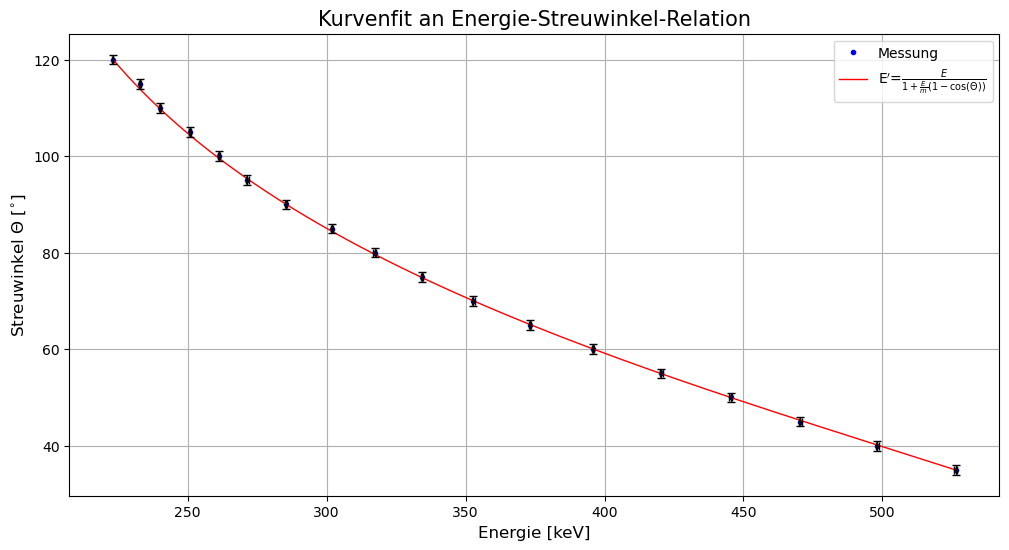

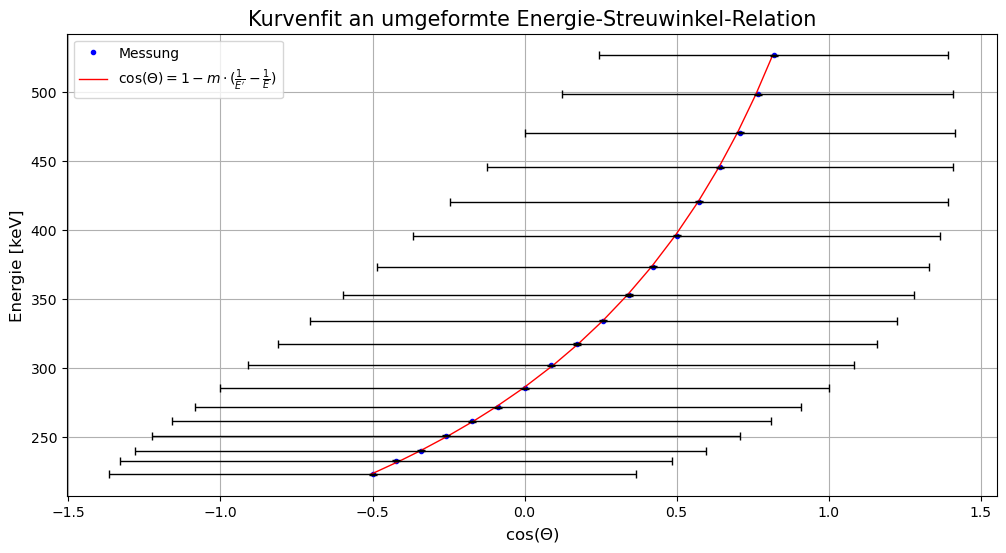

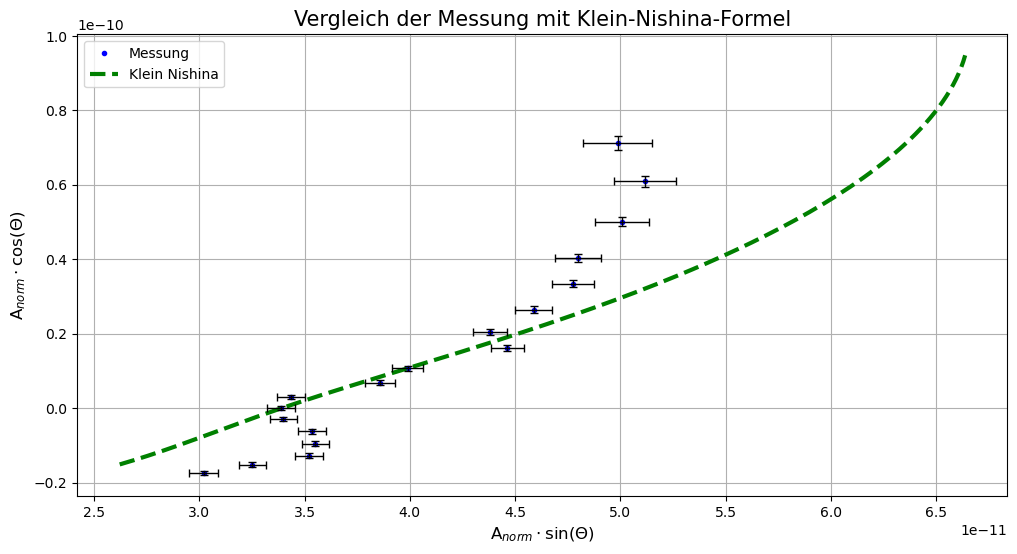

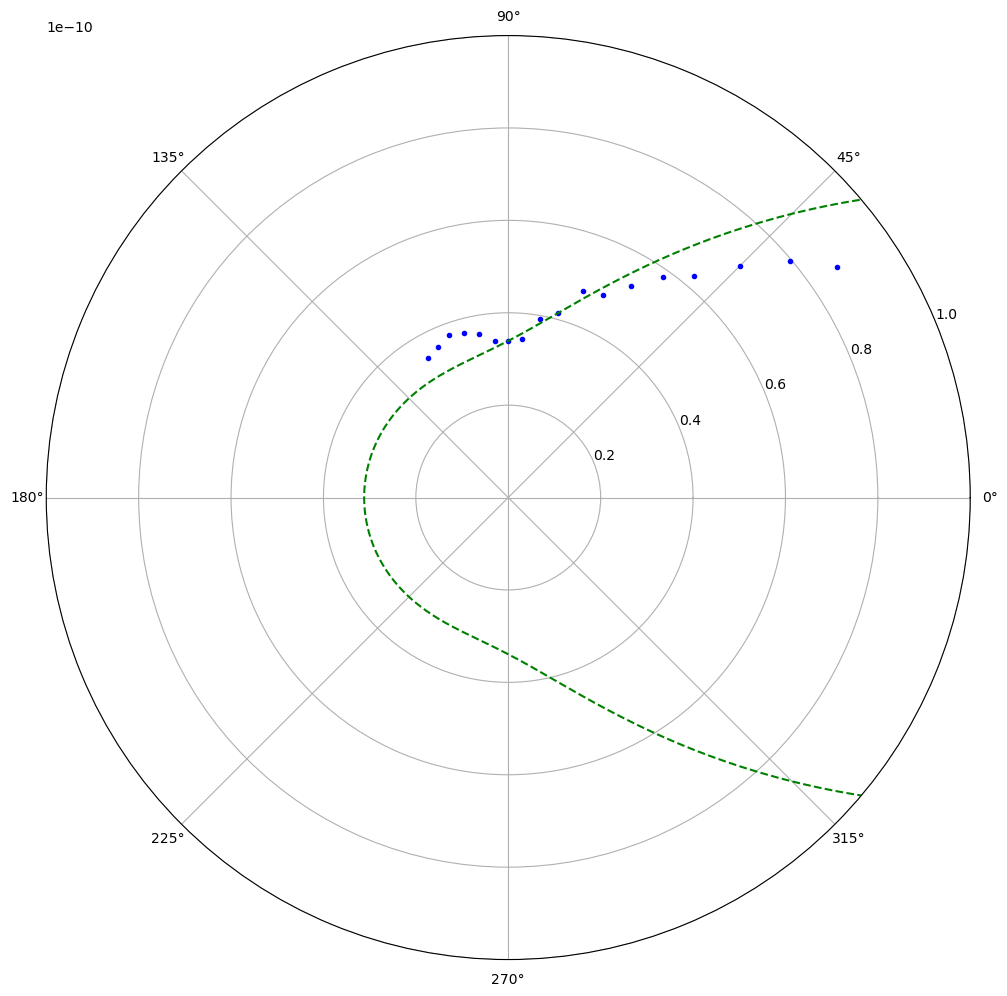

Durch die Anpassung bestimmte Parameter: [  72.92361749    1.74283487 -206.89754912] +/- [ 4.43090437  1.16925256 18.85096945] nm
Durch die Anpassung bestimmte Parameter: [40.69240751 11.18364244] +/- [1.66143392 0.35532163] nm
Durch die Anpassung bestimmte Parameter: [-8.69582245] +/- [1.23056322] nm
Durch die Anpassung bestimmte Parameter: [4.98576993] +/- [0.23736537] nm


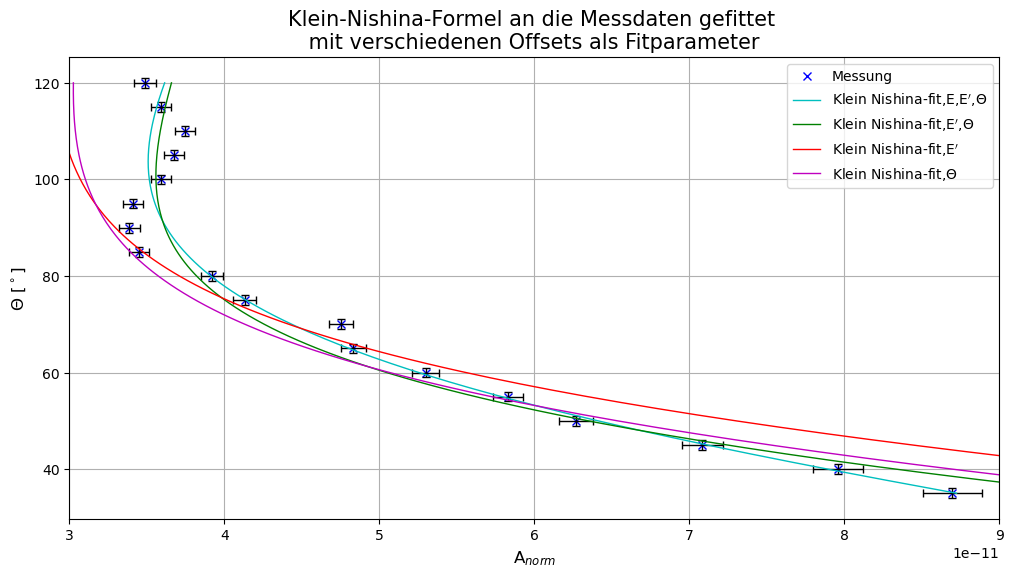

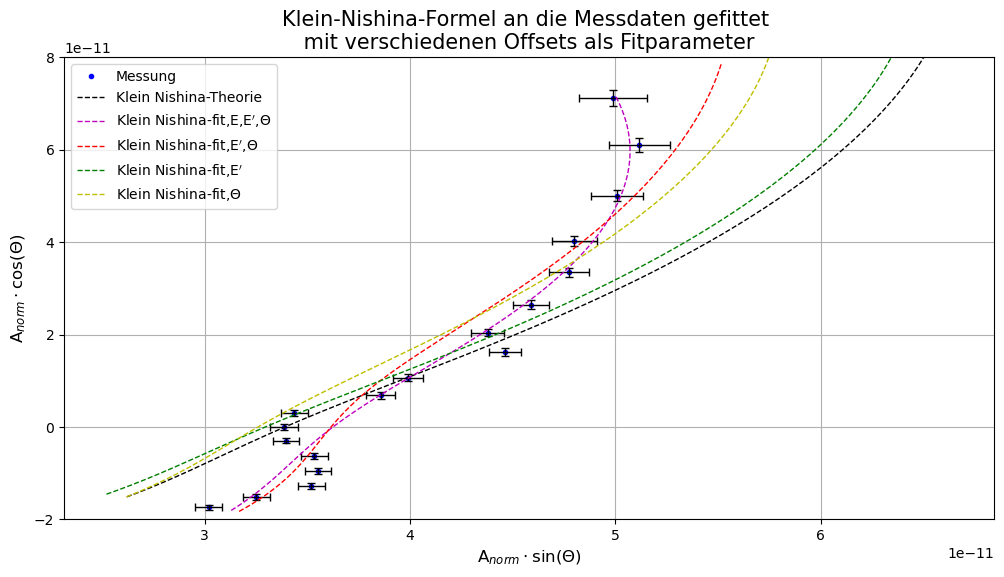

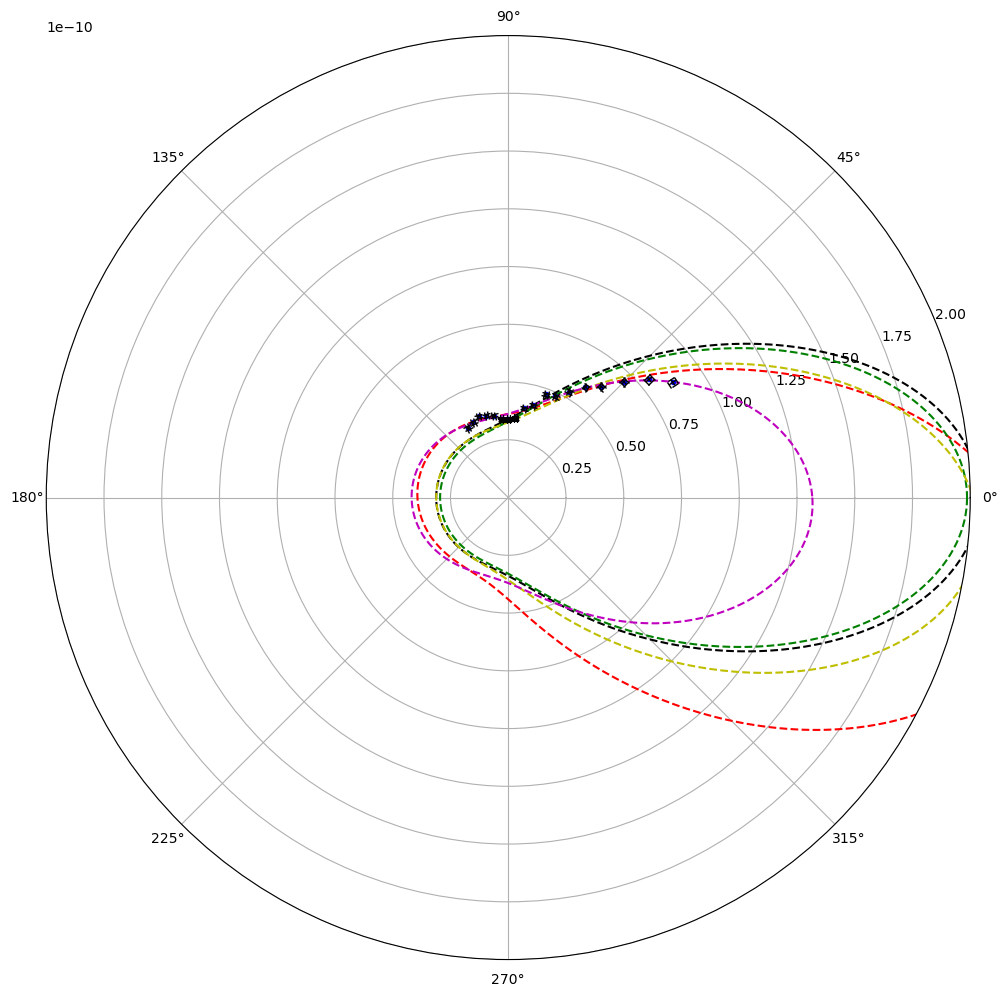

In [ ]:
i=0
A=1.07229309e+00
B=3.26103569e-02 
C=2.34665088e-03 
D=2.16681106e+02
# A=uf(1.07229309e+00,2.29499888e-01)
# B=uf(3.26103569e-02,4.71665917e+05)
# C=uf(2.34665088e-03,2.38166376e-03)
# D=uf(2.16681106e+02,6.16354191e+09)
Amplitudes_cor=[]
Amplitudes_corer=[]
centers=[]
centerser=[]
if ('params' not in locals()) or (len(params)<18):
    params=[]
    params_stderr=[]
    amp=[]
    step=(E_kal(3500,0.16253798, -11.78733577)-E_kal(1200,0.16253798, -11.78733577))/17
    for w in winkel:
        amp.append(E_kal(3500,0.16253798, -11.78733577)-step*i)
        a1,a2=Gauskurvenauswertung(w,'.txt','b.txt',path2,path_raw,path_gaus,1,2000,amp[i],35)
        params.append(a1)
        params_stderr.append(a2)
        i=i+1
print(len(params))
dict1=[list() for x in range(len(params))]
dict2=[list() for x in range(len(params))]
for i in range(0,18):
    dict1[i].append(params[i][0])
    dict1[i].append(params[i][1])
    dict2[i].append(params_stderr[i][0])
    dict2[i].append(params[i][2])
print(dict1,dict2)
vamp=un.uarray(dict1,dict2)
vamp2=un.uarray(params,params_stderr)
for para in params:
    centers.append(para[1])
for vamp in vamp:
    Amplitudes_cor.append((vamp[0]/uEffizienz(vamp[1],A,B,C,D)).n)
    Amplitudes_corer.append((vamp[0]/uEffizienz(vamp[1],A,B,C,D)).s)
for para in params_stderr:
    centerser.append(para[1])

S=[660]
# x_smooth=np.linspace(35,120,num=200)
x_smooth=np.linspace(120,35,num=200)

fit=Fit_smooth(winkel,centers,x_smooth,S,E,winkeler)
figure=plt.figure(figsize=(12,6))
plt.title('Kurvenfit an Energie-Streuwinkel-Relation',fontsize=15)
plt.plot(centers,winkel,"b .",linewidth=1,label='Messung')
plt.plot(fit,x_smooth,"r-",linewidth=1,label='E$^{\prime}$=$\\frac{E}{1+\\frac{E}{m}(1-\cos(\Theta))}$')
plt.errorbar(centers,winkel,winkeler,centerser,'k.',capsize=3,elinewidth=1,markersize=0)
plt.xlabel('Energie [keV]',fontsize=12)
plt.ylabel('Streuwinkel '+ '$\Theta$ [$^{\circ}$]',fontsize=12)
plt.grid()
plt.legend()
plt.savefig('./plots/Ewink.png')


x_kn=[]
y_kn=[]
klni=[]
theta_smooth=[]
cost=[]
x_smooth2=np.linspace(360,0,num=500)
for wwww in x_smooth:
    x1,y1=pol_cords(klein_nishina(647.12702085,wwww),wwww)
    x_kn.append(x1)
    y_kn.append(y1)
klni=[]
theta_smooth=[]
for wwww in x_smooth2:
    klni.append(klein_nishina(647.12702085,wwww))
    theta_smooth.append(wwww*np.pi/180)

theta=[]
thetaer=[]
coster=[]
i=0
for wink in winkel:
    cost.append(np.cos(wink*np.pi/180))
    coster.append(winkeler[i]*np.sin(wink*np.pi/180))
    theta.append(wink*np.pi/180)
    i=i+1
for wink in winkeler:
    thetaer.append(wink*np.pi/180)

# fit=Fit_smooth(centers,cost,centers,S,E2,centerser)
# figure=plt.figure(figsize=(12,6))
# plt.title('Kurvenfit an umgeformte Energie-Streuwinkel-Relation',fontsize=15)
# plt.plot(cost,centers,"b .",linewidth=1,label='Messung')
# plt.plot(fit,centers,"r-",linewidth=1,label='$\cos(\Theta)=1-m \cdot (\\frac{1}{E^{\prime}}-\\frac{1}{E})$')
# plt.errorbar(cost,centers,centerser,coster,'k.',capsize=3,elinewidth=1,markersize=0)
# plt.xlabel('cos($\Theta$)',fontsize=12)
# plt.ylabel('Energie [keV]',fontsize=12)
# plt.grid()
# plt.legend()
# plt.savefig('./plots/winkE.png')

x=[]
y=[]
kn=[]

x_fp=[]
y_fp=[]
x_fit=[]
y_fit=[]
kn_fp=[]
norm_ampl=[]
norm_ampler=[]
kn_vars=[]
print(winkel[8])
for i in range(0,18):
    kn_vars.append(kn_var(winkel[i],centers[i]))
normierung=klein_nishina(647.12702085,winkel[8])/Amplitudes_cor[8]
# normierung=klein_nishina_ebar(646.78086302,winkel[8],centers[8])/Amplitudes_cor[8]
for amp in Amplitudes_cor:
    norm_ampl.append(normierung*amp)
for amp in Amplitudes_corer:
    norm_ampler.append(normierung*amp)
# dict1=[list() for x in range(2)]
# dict2=[list() for x in range(2)]
# dict1[0]=norm_ampl
# dict1[1]=winkel
# dict2[0]=norm_ampler
# dict2[1]=winkeler
# # normuamp=np.concentrate((norm_ampl,winkel))
# # normuamper=np.concatenate(norm_ampler,winkeler)
# unorm=un.uarray(dict1,dict2)
# print(unorm)
S=[0,0,0]
fit=Fit_smooth(winkel,norm_ampl,x_smooth,S,klein_nishina_for_fit,norm_ampler)
fit2=Fit_smooth(winkel,norm_ampl,x_smooth,[0,0],klein_nishina_for_fit_no_E_off,norm_ampler)
fit3=Fit_smooth(winkel,norm_ampl,x_smooth,[0],klein_nishina_for_fit_no_E_off_and_theta_off,norm_ampler)
fit4=Fit_smooth(winkel,norm_ampl,x_smooth,[0],klein_nishina_for_fit_no_E_off_and_E_bar_off,norm_ampler)
for i in range(0,18):
    x1,y1=pol_cords(fit[i],winkel[i])
    x_fit.append(x1)
    y_fit.append(y1)
    x1,y1=pol_cords(knff(kn_vars[i],S[0]),winkel[i])
    kn_fp.append(knff(kn_vars[i],S[0]))
    x_fp.append(x1)
    y_fp.append(y1)
    x1,y1=pol_cords(normierung*Amplitudes_cor[i],winkel[i])
    kn.append(klein_nishina(647.12702085,winkel[i]))
    # kn.append(klein_nishina_ebar(646.78086302,winkel[i],centers[i]))
    x.append(x1)
    y.append(y1)


# print(uwink[1])
# xx=[]
# yy=[]
# xxer=[]
# yyer=[]
# for un in unorm:
#     print(upol_cords_for_list_x(un[0],un[1]))
#     xx.append(1*upol_cords_for_list_x(un[0],un[1]).n)
#     yy.append(upol_cords_for_list_y(un[0],un[1]).n)
#     xxer.append(1*upol_cords_for_list_x(un[0],un[1]).s)
#     yyer.append(upol_cords_for_list_y(un[0],un[1]).s)
unorm=un.uarray(norm_ampl,norm_ampler)
uwink=un.uarray(winkel,winkeler)
# print(plot4kord(unorm,uwink))
# print(un.nominal_values(upol_cords_for_list_x(unorm,uwink)))
figure=plt.figure(figsize=(12,6))
plt.title('Vergleich der Messung mit Klein-Nishina-Formel',fontsize=15)
# plt.plot(x,y,"b .",linewidth=3,label='Messung')
plt.plot(pol_cords_for_list_x(norm_ampl,winkel),pol_cords_for_list_y(norm_ampl,winkel),"b .",linewidth=5,label='Messung')
plt.plot(x_kn,y_kn,"g--",linewidth=3,label='Klein Nishina')
plt.errorbar(un.nominal_values(upol_cords_for_list_x(unorm,uwink)),un.nominal_values(upol_cords_for_list_y(unorm,uwink)),un.std_devs(upol_cords_for_list_y(unorm,uwink)),un.std_devs(upol_cords_for_list_x(unorm,uwink)),'k.',capsize=3,elinewidth=1,markersize=0,)
plt.xlabel('A$_{norm}\cdot\sin(\Theta)$',fontsize=12)
plt.ylabel('A$_{norm}\cdot\cos(\Theta)$',fontsize=12)
# plt.xticks(np.arange(0, 8000, 200))
plt.grid()
plt.legend()
plt.savefig('./plots/KleinNishina.png')


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(12,12))
ax.plot(theta, norm_ampl, 'b .')
ax.plot(theta_smooth,klni, 'g--')
ax.set_rmax(1e-10)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
# ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

figure=plt.figure(figsize=(12,6))
plt.title('Klein-Nishina-Formel an die Messdaten gefittet \n mit verschiedenen Offsets als Fitparameter ',fontsize=15)
plt.plot(norm_ampl,winkel,"b x",linewidth=5,label='Messung')
plt.errorbar(un.nominal_values(unorm),un.nominal_values(uwink),un.std_devs(uwink),un.std_devs(unorm),'k.',capsize=3,elinewidth=1,markersize=0)
# plt.plot(x_kn,y_kn,"g-",linewidth=1,label='Klein Nishina')
plt.plot(fit,x_smooth,"c-",linewidth=1,label='Klein Nishina-fit,E,E$^\prime$,$\Theta$')
plt.plot(fit2,x_smooth,"g-",linewidth=1,label='Klein Nishina-fit,E$^\prime$,$\Theta$')
plt.plot(fit3,x_smooth,"r-",linewidth=1,label='Klein Nishina-fit,E$^\prime$')
plt.plot(fit4,x_smooth,"m-",linewidth=1,label='Klein Nishina-fit,$\Theta$')
# plt.plot(fit,winkel,"c-",linewidth=1,label='Klein Nishina-fit')
# plt.plot(fit2,winkel,"g-",linewidth=1,label='Klein Nishina-fit')
# plt.plot(fit3,winkel,"r-",linewidth=1,label='Klein Nishina-fit')
# plt.plot(fit4,winkel,"m-",linewidth=1,label='Klein Nishina-fit')
# plt.plot(knff(kn_vars[i],S[0]),winkel,"r .",linewidth=2,label='Messung')
plt.xlim([0.3e-10,0.9e-10])
plt.xlabel('A$_{norm}$',fontsize=12)
plt.ylabel('$\Theta$ [$^\circ$]',fontsize=12)
# plt.xticks(np.arange(0, 8000, 200))
plt.grid()
plt.legend()
plt.savefig('./plots/syst1.png')

figure=plt.figure(figsize=(12,6))
plt.title('Klein-Nishina-Formel an die Messdaten gefittet \n mit verschiedenen Offsets als Fitparameter ',fontsize=15)
# plt.plot(x,y,"b .",linewidth=3,label='Messung')
plt.plot(pol_cords_for_list_x(norm_ampl,winkel),pol_cords_for_list_y(norm_ampl,winkel),"b .",linewidth=5,label='Messung')
plt.plot(x_kn,y_kn,"k--",linewidth=1,label='Klein Nishina-Theorie')
plt.errorbar(un.nominal_values(upol_cords_for_list_x(unorm,uwink)),un.nominal_values(upol_cords_for_list_y(unorm,uwink)),un.std_devs(upol_cords_for_list_y(unorm,uwink)),un.std_devs(upol_cords_for_list_x(unorm,uwink)),'k.',capsize=3,elinewidth=1,markersize=0)
# plt.plot(pol_cords_for_list_x(fit,winkel),pol_cords_for_list_y(fit,winkel),"y--",linewidth=1,label='Klein Nishina-fit,E,Eb,wink')
# plt.plot(pol_cords_for_list_x(fit2,winkel),pol_cords_for_list_y(fit2,winkel),"r--",linewidth=1,label='Klein Nishina-fit,Eb,wink')
# plt.plot(pol_cords_for_list_x(fit3,winkel),pol_cords_for_list_y(fit3,winkel),"g--",linewidth=1,label='Klein Nishina-fit,Eb')
# plt.plot(pol_cords_for_list_x(fit4,winkel),pol_cords_for_list_y(fit4,winkel),"m--",linewidth=1,label='Klein Nishina-fit,Eb')
plt.plot(pol_cords_for_list_x(fit,x_smooth),pol_cords_for_list_y(fit,x_smooth),"m--",linewidth=1,label='Klein Nishina-fit,E,E$^\prime$,$\Theta$')
plt.plot(pol_cords_for_list_x(fit2,x_smooth),pol_cords_for_list_y(fit2,x_smooth),"r--",linewidth=1,label='Klein Nishina-fit,E$^\prime$,$\Theta$')
plt.plot(pol_cords_for_list_x(fit3,x_smooth),pol_cords_for_list_y(fit3,x_smooth),"g--",linewidth=1,label='Klein Nishina-fit,E$^\prime$')
plt.plot(pol_cords_for_list_x(fit4,x_smooth),pol_cords_for_list_y(fit4,x_smooth),"y--",linewidth=1,label='Klein Nishina-fit,$\Theta$')
# plt.plot(x_fp,y_fp,"r .",linewidth=2,label='Messung')
plt.ylim([-0.2e-10,0.8e-10])
plt.xlabel('A$_{norm}\cdot\sin(\Theta)$',fontsize=12)
plt.ylabel('A$_{norm}\cdot\cos(\Theta)$',fontsize=12)
# plt.xticks(np.arange(0, 8000, 200))
plt.grid()
plt.legend()
plt.savefig('./plots/syst2.png')

S=[0,0,0]
fit=Fit_smooth(winkel,norm_ampl,x_smooth2,S,klein_nishina_for_fit,norm_ampler)
fit2=Fit_smooth(winkel,norm_ampl,x_smooth2,[0,0],klein_nishina_for_fit_no_E_off,norm_ampler)
fit3=Fit_smooth(winkel,norm_ampl,x_smooth2,[0],klein_nishina_for_fit_no_E_off_and_theta_off,norm_ampler)
fit4=Fit_smooth(winkel,norm_ampl,x_smooth2,[0],klein_nishina_for_fit_no_E_off_and_E_bar_off,norm_ampler)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(12,12))
ax.plot(theta_smooth,klni, 'k--')
ax.plot(theta_smooth,fit2, 'r--')
ax.plot(theta_smooth,fit3, 'g--')
ax.plot(theta_smooth,fit4, 'y--')
ax.plot(theta_smooth,fit, 'm--')
ax.plot(theta, norm_ampl, 'b .',linewidth=5,label='Messung')
plt.errorbar(theta,norm_ampl,norm_ampler,thetaer,'k.',capsize=3,elinewidth=1,markersize=0)
ax.set_rmax(2e-10)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
# ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

# with open('./Data/'+'Tab3'+'.txt', 'w') as f:
#     count=0
#     f.write('$\Theta$[$^{\circ}$]&Amplitude&Zentrum&$\sigma$'+'\\'+'\\'+'\n'+'\hline'+'\n')
#     for count in range(0,7):
#         f.write(str(np.round(E_list[count],3))+'$\pm$'+str(np.round(dE_list[count],3))+'&'+str(int(np.round(params[count][0],1)))+ '$\pm$' + str(int(np.round(params_stderr[count][0],1)))+'&'+str(np.round(params[count][1],1))+ '$\pm$' + str(np.round(params_stderr[count][1],1))+'&'+str(np.round(params[count][2],1))+'$\pm$'+str(np.round(params_stderr[count][2],1))+'\\'+'\\'+'\n')
#         count=count+1


In [4]:
allfiles=glob.glob(path1+'*.txt')
print(allfiles)
chanel=[]
count=[]
x_=[]
y_=[]
i=0
for h in allfiles:
    data=np.loadtxt(h)
    chanel.append(data[:,0])
    count.append(data[:,1])
    mask=((chanel[i]>3600))
    x_.append(chanel[i][mask])
    y_.append(count[i][mask])
    i=i+1
print(x_[1][1])

['../Versuch 526/Rohdaten\\Cs10,18mm.txt', '../Versuch 526/Rohdaten\\Cs1mm.txt', '../Versuch 526/Rohdaten\\Cs20,2mm.txt', '../Versuch 526/Rohdaten\\Cs5,06mm.txt', '../Versuch 526/Rohdaten\\CsHintergrundTot.txt', '../Versuch 526/Rohdaten\\CsSpektrum.txt']
3602.0


c:\Users\Banton\anaconda3\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Durch die Anpassung bestimmte Parameter: [  0.16253806 -11.78745907] +/- [4.16594532e-07 5.14729680e-04] nm


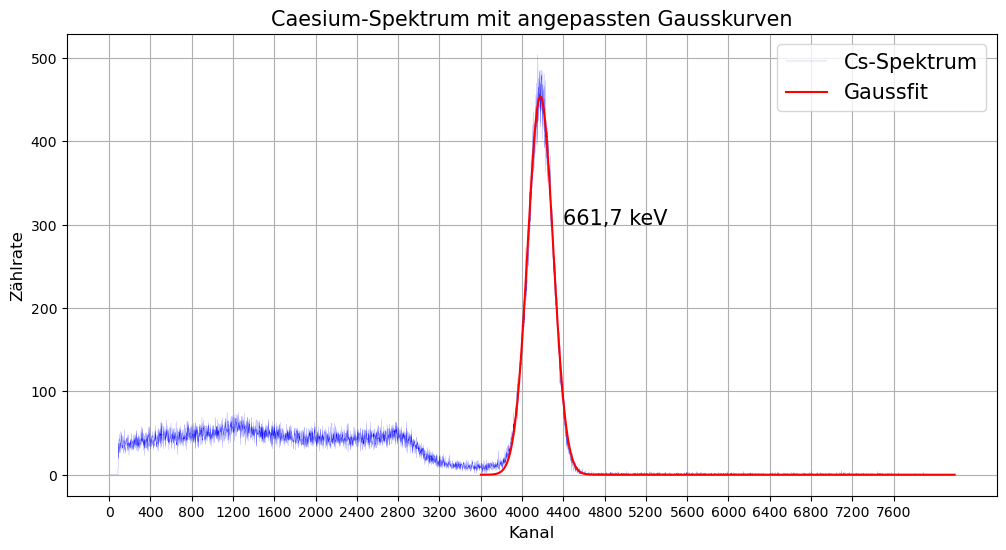

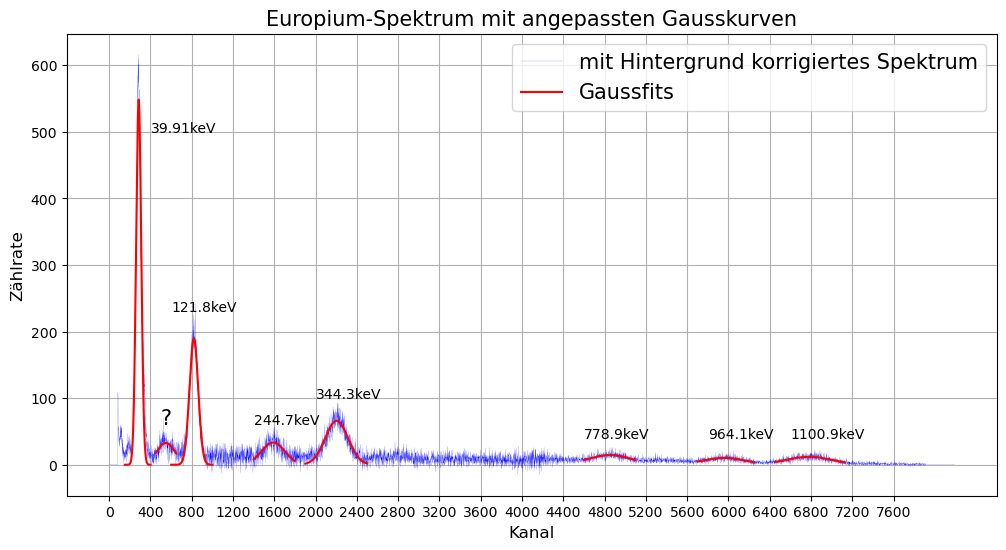

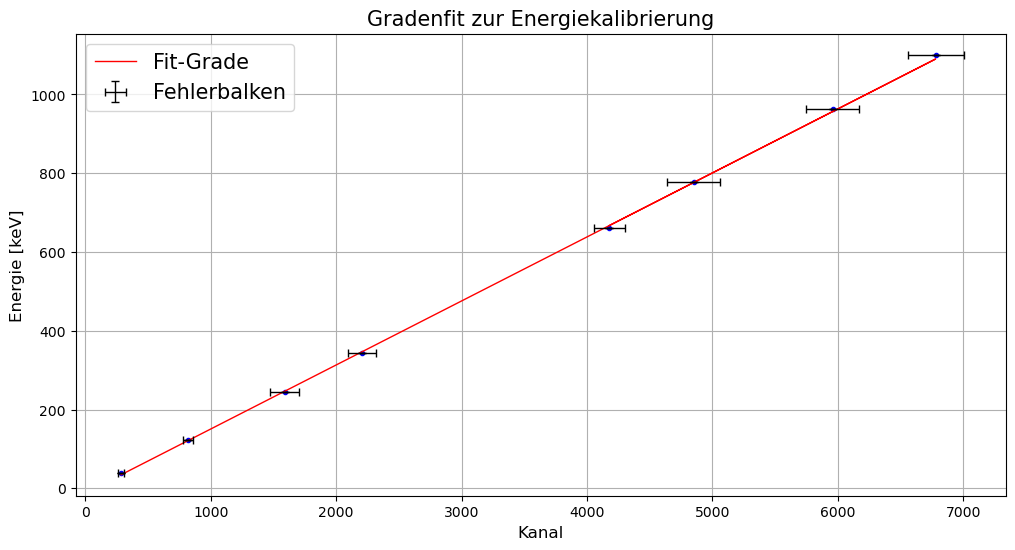

In [7]:
names=glob.glob(path2+'Eu*.txt')
# print(names)
data=np.loadtxt(names[1])
databg=np.loadtxt(names[0])
k=data[:,0]
kb=databg[:,0]
I=data[:,1]
Ibg=databg[:,1]
I2=I-Ibg
#,
range2=[450,650]
mask4=((k>range2[0]) & (k<range2[1]))
x_wo2=k[mask4]
y_wo2=I2[mask4]
# ranges=[150,400,600,1000,1400,1800,1900,2500,4500,5200,5600,6300,6300,7600]
ranges=[150,400,600,1000,1400,1800,1900,2500,4600,5100,5700,6250,6450,7130]
E_list=[39.91,121.8,244.7,344.3,778.9,964.1,1100.9,661.7]
dE_list=[0.1,0.0003,0.0008,0.0012,0.0024,0.005,0.01,0.1]
rel=[28.53,7.55,27.57,13.44,14.65,25.70]
rel2=[28.53,27.57,13.44,14.65,25.70,85.1]
count=int(len(ranges)/2)
zeros=np.zeros(len(k))
all=np.sum(I-Ibg)
III=[]
params=[]
params_stderr=[]
bestfits=[]
for i in range(0,7):
    mask=((k>ranges[2*i]) & (k<ranges[2*i+1]))
    antimaskdown=((k<=ranges[2*i]))
    antimaskup=((k>=ranges[2*i+1]))
    x_=k
    III.append(x_[mask])
    y_=np.concatenate((zeros[antimaskdown],I2[mask],zeros[antimaskup]))
    # print(len(x_))
    # print(len(y_))
    center=(ranges[2*i]+ranges[2*i+1])/2
    if i==7:
        a1,a2,a3=Gausfit_2(x_,y_,4000,center,200)
    else:
        # a1,a2,a3=Gausfit_11(x_,y_,4000,center,200)
        a1,a2,a3=Gausfit_11(x_[mask],I2[mask],4000,center,200)
    params.append(a1)
    params_stderr.append(a2)
    bestfits.append(a3)
data2=np.loadtxt('../Versuch 526/Rohdaten/CsSpektrum.txt')
Xcs=data2[:,0]
Ycs=data2[:,1]
mask2=(Xcs>3600)
X=Xcs[mask2]
Y=Ycs[mask2]
lbl,lbl2,lbl3=Gausfit_11(X,Y,4000,4000,200)
yeet1,yeet2,yeet3=Gausfit_11(x_wo2,y_wo2,4000,550,200)

figure=plt.figure(figsize=(12,6))
plt.title('Caesium-Spektrum mit angepassten Gausskurven',fontsize=15)
plt.plot(Xcs,Ycs,"b",linewidth=0.1,label='Cs-Spektrum')
plt.plot(X,lbl3,"r", label='Gaussfit')
plt.text(4400,300, '661,7 keV', fontsize = 15)
plt.xlabel('Kanal',fontsize=12)
plt.ylabel('Zählrate',fontsize=12)
plt.xticks(np.arange(0, 8000, 400))
plt.grid()
plt.legend(fontsize=15)
plt.savefig('./plots/Csfit.png')

pos_x=[600,800,1600,2200,4800,6000,6800]
pos_y=[500,230,60,100,40,40,40]
mask3=(x_>700)
all2=np.sum(I2[mask3])
# Plot_raw(k,kb,I,Ibg,'lbl',path_raw,0)
figure=plt.figure(figsize=(12,6))
plt.title('Europium-Spektrum mit angepassten Gausskurven',fontsize=15)
plt.plot(x_,I2,"b",linewidth=0.1,label='mit Hintergrund korrigiertes Spektrum')
plt.plot(x_wo2,yeet3,"r", label='Gaussfits')
plt.text( 500,60, '?', fontsize = 15)
for i in range(0,7):
    # plt.plot(x_,bestfits[i],'r')
    plt.plot(III[i],bestfits[i],'r')
    plt.text( pos_x[i]-200,pos_y[i], str(E_list[i])+'keV', fontsize = 10)
    # print(params[i])
plt.xlabel('Kanal',fontsize=12)
plt.ylabel('Zählrate',fontsize=12)
plt.xticks(np.arange(0, 8000, 400))
plt.grid()
plt.legend(fontsize=15)
plt.savefig('./plots/Eufits.png')

figure=plt.figure(figsize=(12,6))
plt.title('Rohdaten der Messung zur Energiekalibration',fontsize=15)
plt.plot(x_,I,"b",linewidth=0.3,label='Eu')
plt.plot(x_,Ibg,"r",linewidth=0.2,label='Hintergrund')
plt.xlabel('Kanal',fontsize=12)
plt.ylabel('Zählrate',fontsize=12)
plt.xticks(np.arange(0, 8000, 400))
plt.grid()
plt.legend(fontsize=15)
plt.savefig('./plots/Euraw.png')
plt.close(figure)
centers=[]
centers_err=[]
for i in range(0,7):
    centers_err.append(params[i][2])
    centers.append(params[i][1])
# centers.append(params[2][4])
centers.append(lbl[1])
centers_err.append(lbl[2])
# print(centers)
# print(params)
S=[1,1]
# fit=Gradenfit(centers,E_list)
fit=Fit(centers,E_list,S,E_kal,dE_list)
figure=plt.figure(figsize=(12,6))
plt.title('Gradenfit zur Energiekalibrierung',fontsize=15)
plt.plot(centers,E_list,"b .",linewidth=1)
plt.plot(centers,fit,"r-",linewidth=1, label='Fit-Grade')
plt.errorbar(centers,E_list,dE_list,centers_err,'k.',capsize=3,elinewidth=1,markersize=0,label='Fehlerbalken')
plt.xlabel('Kanal',fontsize=12)
plt.ylabel('Energie [keV]',fontsize=12)
plt.grid()
plt.legend(fontsize=15)
plt.savefig('./plots/Ekalgrade.png')


1
3
4
5
6
[20160.634712429568+/-245.92554669551072
 18329.842153504513+/-240.9172985843108
 7553.64057014588+/-223.67866770249807
 5391.996081134263+/-163.69773715687447
 6632.153546114488+/-140.59272281027626]
[1.0, 0.9408481382122429, 0.7953432833555656, 0.5208462169094099, 0.3651901203782896]
[122.56776304937796, 348.60273000693684, 781.0038254911095, 962.0386673906646, 1096.3728029017218]
[20160.634712429568, 18329.842153504513, 7553.64057014588, 5391.996081134263, 6632.153546114488]
[1.666456324980988e-18, 0.016871083547044145, 0.025471745279436336, 0.017041237051202276, 0.008931728490957703]
Durch die Anpassung bestimmte Parameter: [1.07229309e+00 3.26103569e-02 2.34665088e-03 2.16681106e+02] +/- [2.29499888e-01 4.71665917e+05 2.38166376e-03 6.16354191e+09] nm


C:\Users\Banton\AppData\Local\Temp\ipykernel_6732\2220328695.py:31: RuntimeWarning: overflow encountered in exp
  return A-B*np.exp(C*(E+D))


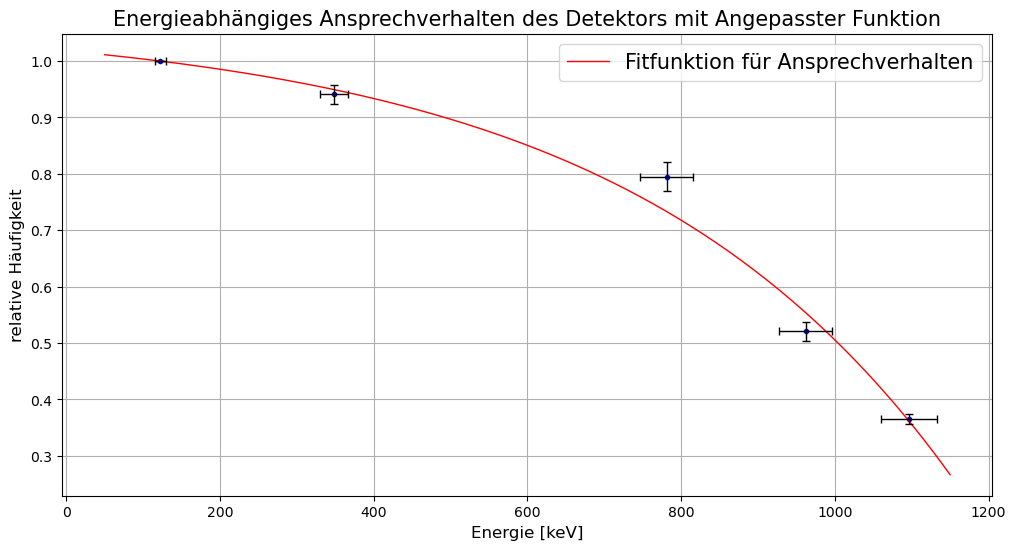

In [9]:
amplidudes=[]
centers=[]
amplidudeser=[]
centerser=[]
resp=[]
resperr=[]
para=[]
para_err=[]
params.append(lbl)
params_stderr.append(lbl2)
for i in range(1,7):
    if i!=2:
        para.append(params[i])
        para_err.append(params_stderr[i])
        print(i)
for i in range(0,5):
    amplidudes.append(para[i][0])
    centers.append(0.16341508*para[i][1]-11.45483454)
    amplidudeser.append(para_err[i][0])
    centerser.append(0.16341508*para[i][2])
vamp=un.uarray(amplidudes,amplidudeser)
vcent=un.uarray(centers,centerser)
print(vamp)
for i in range(0,5):
    resp.append((vamp[i]*rel2[0]/(vamp[0]*rel2[i])).n)
    resperr.append((vamp[i]*rel2[0]/(vamp[0]*rel2[i])).s)
print(resp)
# centers.append(0.16341508*params[2][4]-11.45483454)
# amplidudes.append(params[2][3])
# resp.append(amplidudes[7]*rel[7]/(amplidudes[0]*rel[6]))
print(centers)
print(amplidudes)
print(resperr)
S=[1.0131286,0.01878647,0.00324241,8.34148682]
x_smooth=np.linspace(50,1150,num=200)
fit=Fit_smooth(centers,resp,x_smooth,S,Effizienz,resperr)
figure=plt.figure(figsize=(12,6))
plt.title('Energieabhängiges Ansprechverhalten des Detektors mit Angepasster Funktion',fontsize=15)
plt.plot(centers,resp,"b .",linewidth=2)
plt.plot(x_smooth,fit,"r-",linewidth=1,label='Fitfunktion für Ansprechverhalten')
plt.errorbar(centers,resp,resperr,centerser,'k.',capsize=3,elinewidth=1,markersize=0)
plt.xlabel('Energie [keV]',fontsize=12)
plt.ylabel('relative Häufigkeit',fontsize=12)
plt.grid()
plt.legend(fontsize=15)
plt.savefig('./plots/AnsprechwahrscheinlichkeitmitFit.png')
            

[20160.634712429568+/-245.92554669551072
 9419.710813624431+/-265.89730341832654
 18329.842153504513+/-240.9172985843108
 7553.64057014588+/-223.67866770249807
 5391.996081134263+/-163.69773715687447
 6632.153546114488+/-140.59272281027626]
[122.56776304937796, 248.08033214522058, 348.60273000693684, 781.0038254911095, 962.0386673906646, 1096.3728029017218]
[20160.634712429568, 9419.710813624431, 18329.842153504513, 7553.64057014588, 5391.996081134263, 6632.153546114488]
[1.0, 1.7655832065251178, 0.9408481382122429, 0.7953432833555656, 0.5208462169094099, 0.3651901203782896]


C:\Users\Banton\AppData\Local\Temp\ipykernel_5852\1099552462.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=15)


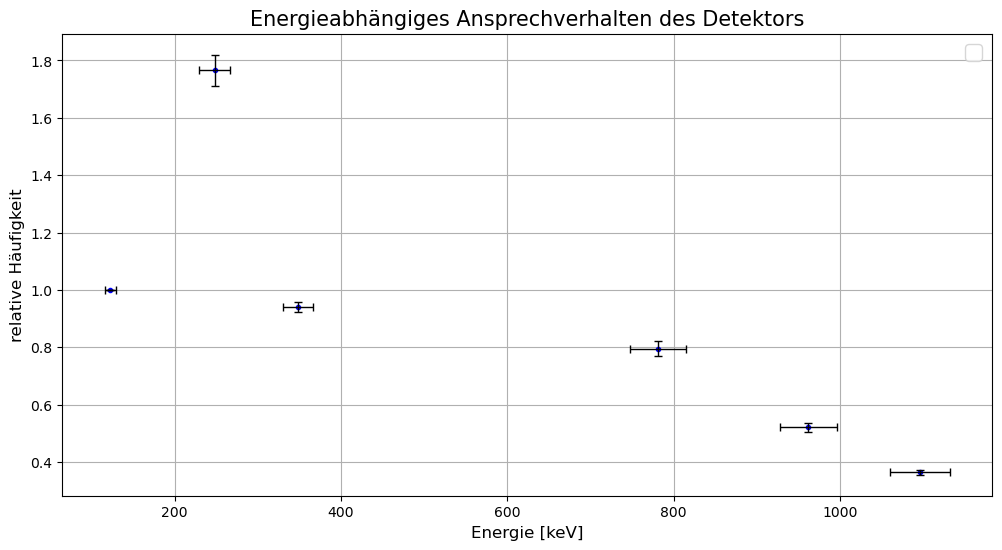

In [ ]:
amplidudes=[]
centers=[]
resp=[]
amplidudeser=[]
centerser=[]
resperr=[]
for i in range(1,7):
    amplidudes.append(params[i][0])
    centers.append(0.16341508*params[i][1]-11.45483454)
    amplidudeser.append(params_stderr[i][0])
    centerser.append(0.16341508*params[i][2])
# centers.append(0.16341508*params[2][4]-11.45483454)
vamp=un.uarray(amplidudes,amplidudeser)
vcent=un.uarray(centers,centerser)
print(vamp)
for i in range(0,6):
    resp.append((vamp[i]*rel[0]/(vamp[0]*rel[i])).n)
    resperr.append((vamp[i]*rel[0]/(vamp[0]*rel[i])).s)
# amplidudes.append(params[2][3])
# resp.append(amplidudes[7]*rel[7]/(amplidudes[0]*rel[6]))
print(centers)
print(amplidudes)
print(resp)
S=[0.002,0.0137]
figure=plt.figure(figsize=(12,6))
plt.title('Energieabhängiges Ansprechverhalten des Detektors',fontsize=15)
plt.plot(centers,resp,"b .",linewidth=2)
plt.errorbar(centers,resp,resperr,centerser,'k.',capsize=3,elinewidth=1,markersize=0)
plt.xlabel('Energie [keV]',fontsize=12)
plt.ylabel('relative Häufigkeit',fontsize=12)
plt.grid()
plt.legend(fontsize=15)
plt.savefig('./plots/Ansprechwahrscheinlichkeit.png')
            

['../Versuch 526/Rohdaten\\Cs10,18mm.txt', '../Versuch 526/Rohdaten\\Cs1mm.txt', '../Versuch 526/Rohdaten\\Cs20,2mm.txt', '../Versuch 526/Rohdaten\\Cs5,06mm.txt', '../Versuch 526/Rohdaten\\CsHintergrundTot.txt', '../Versuch 526/Rohdaten\\CsSpektrum.txt']
../Versuch 526/Rohdaten\Cs10,18mm.txt
../Versuch 526/Rohdaten\Cs1mm.txt
../Versuch 526/Rohdaten\Cs20,2mm.txt
../Versuch 526/Rohdaten\Cs5,06mm.txt
../Versuch 526/Rohdaten\CsHintergrundTot.txt
../Versuch 526/Rohdaten\CsSpektrum.txt
[230023.4197538401, 4158.815172345902, 122.28895167337767, 287.9684691795032, 750.4036208893261]
[275091.411086259, 4167.507525308496, 122.24107308931048, 287.85572373217013, 897.7800789495402]
[190454.63255148087, 4157.953816291156, 122.27054809381127, 287.9251320622687, 621.412190754614]
[254952.69780443373, 4162.736563440771, 122.3642081343949, 288.1456845990358, 831.2186807239761]
[280371.3698517352, 4172.141779917767, 122.0033758200998, 287.29598944868746, 916.7942968048144]
[230023.4197538401, 275091.411

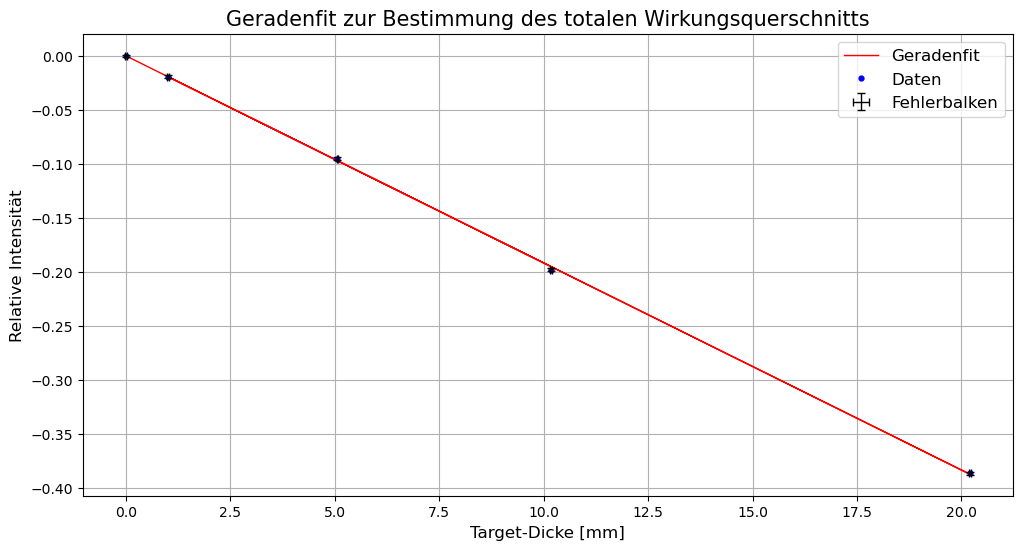

In [ ]:
def Gausfit_1(x,y,namena,amplitude,center,sigma,dont_show):
    x1 = x
    y1 = y
    model = (GaussianModel(prefix='g1_'))
    params = model.make_params(g1_amplitude=amplitude,
                            g1_center=center,
                            g1_sigma=sigma)
    result = model.fit(y1, params, x=x1)
    # print(result.fit_report(min_correl=0.5))
    lolo1=[]
    lala1=[]
    for name,param in result.params.items():
        if result.errorbars==True:
            lala1.append(param.stderr)
        else:
            lala1.append(0)
        lolo1.append(param.value)
    comps = result.eval_components(x=x1)
    dely = result.eval_uncertainty(sigma=3)
    ergebnis = model.eval(params,x=x1)
    figure=plt.figure(figsize=(6,6))
    plt.title('Gaußkurvenfit an das Cäsiumspektrum ohne Target',fontsize=15)
    plt.plot(x1,y1,"b-",linewidth=.2,label="Messwerte",)
    plt.plot(chanel,count,"b-",linewidth=.2)
    plt.plot(x1,result.best_fit,"r-",label="Gaußkurve",)
    plt.xlabel('Kanal',fontsize=12)
    plt.ylabel('Zählrate',fontsize=12)
    plt.grid()
    plt.legend(fontsize=12)
    #plt.savefig(namena+'.png')
    if (dont_show==1):
        plt.close(figure)
    #plt.show
    return lolo1,lala1
parameter=[]
parameter_err=[]

allfiles=glob.glob(path1+'*.txt')
print(allfiles)
chanel=[]
count=[]
x_=[]
y_=[]
i=0
for h in allfiles:
    data=np.loadtxt(h)
    chanel.append(data[:,0])
    count.append(data[:,1])
    mask=((chanel[i]>3600))
    x_.append(chanel[i][mask])
    y_.append(count[i][mask])
    i=i+1
    print(h)
    
a,b=Gausfit_1(x_[0],y_[0],'Cs1mm',480,4200,100,1)
parameter.append(a)
parameter_err.append(b)
a,b=Gausfit_1(x_[1],y_[1],'Cs5,06',480,4200,100,1)
parameter.append(a)
parameter_err.append(b)
a,b=Gausfit_1(x_[2],y_[2],'Cs10,18mm',480,4200,100,1)
parameter.append(a)
parameter_err.append(b)
a,b=Gausfit_1(x_[3],y_[3],'Cs20,2mm',480,4200,100,1)
parameter.append(a)
parameter_err.append(b)
a,b=Gausfit_1(x_[4],y_[4],'dd',480,4200,100,1)
parameter.append(a)
parameter_err.append(b)

for h in parameter: 
    print(h)
#print(parameter_err)


f=[]
ferr=[]
g=[]
gerr=[]
haha=[10.18,1,20.2,5.06,0]
hahaerr=[0.02,0.02,0.02,0.02,0.02]
gerr=[]
for h in parameter:
    f.append(h[0])
for h in parameter_err:
    ferr.append(h[0])
print(f)
print(ferr)
for h in f:
    x=np.log(h/f[4])
    g.append(x)
i=0
for h in ferr:
    x=np.sqrt((h/f[i])**2+(ferr[4]/f[4])**2)
    gerr.append(x)
    i=i+1
print(haha)
print(g)
print(gerr)


anpassungs_werte, co_var = curve_fit(E_kal,haha,g)
perr= np.sqrt(np.diag(co_var))
print("Durch die Anpassung bestimmte Parameter:", anpassungs_werte, "+/-", perr)
Rfit=[]
for E in haha:
    Rfit.append(E_kal(E, *anpassungs_werte))

plt.figure(figsize=(12,6))
plt.title('Geradenfit zur Bestimmung des totalen Wirkungsquerschnitts',fontsize=15)
plt.plot(haha,Rfit,"r-",linewidth=1,label='Geradenfit')
plt.plot(haha,g,"b.",markersize=7,label="Daten",)
plt.errorbar(haha,g,gerr,hahaerr,'k.',capsize=3,elinewidth=1,markersize=0,label='Fehlerbalken')
#plt.plot(x1,result.best_fit,"r-",label="Gaußkurve",)
plt.xlabel('Target-Dicke [mm]',fontsize=12)
plt.ylabel('Relative Intensität',fontsize=12)
plt.grid()
plt.legend(fontsize=12)
#plt.savefig(Wirkungsquerschnitt'.png')




Note: you may need to restart the kernel to use updated packages.
